In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from skimage import io
%matplotlib inline

from aux_fun import *

In [2]:
pos_image_fnames = glob.glob('data/vehicles/KITTI_extracted/*.png')
neg_image_fnames = glob.glob('data/non-vehicles/Extras/extra*.png')

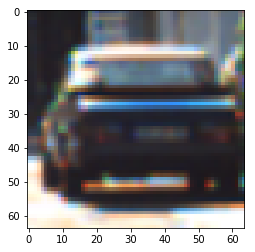

In [3]:
test_car = io.imread(pos_image_fnames[0])
plt.imshow(test_car);

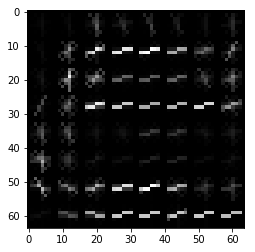

In [4]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

features, hog_image = extract_hog_features(
    cv2.cvtColor(test_car, cv2.COLOR_RGB2LUV)[:,:,0],
    orientations=9, 
    pixels_per_cell=8, 
    cells_per_block=2, 
    vis=True
)

plt.imshow(hog_image, cmap='gray');

In [5]:
def extract_single_img_features(img_rgb):
    img_features = list()
    img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LUV)
    #img_features.append(extract_spatial_features(img_rgb))
    #img_features.append(extract_hist_features(img_rgb))
    img_features.append(extract_hog_features(img_luv[:,:,0], orientations=9, pixels_per_cell=8, cells_per_block=2))
    return np.concatenate(img_features)

In [6]:
def extract_features_from_img_file_list(img_fname_list):
    feature_list = list()
    for img_fname in img_fname_list:
        img_features = list()
        img_rgb = io.imread(img_fname)
        feature_list.append(extract_single_img_features(img_rgb))
    return np.vstack(feature_list)

In [7]:
from sklearn.utils import shuffle
def build_dataset(positive_fname_list, negative_fname_list):
    X_0 = extract_features_from_img_file_list(negative_fname_list)
    y_0 = np.zeros(X_0.shape[0])
    X_1 = extract_features_from_img_file_list(positive_fname_list)
    y_1 = np.ones(X_1.shape[0])
    return shuffle(np.vstack([X_0, X_1]), np.concatenate([y_0, y_1]))

In [8]:
X, y = build_dataset(pos_image_fnames, neg_image_fnames)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
from xgboost import XGBClassifier
clf = XGBClassifier()

In [11]:
from sklearn.model_selection import cross_val_score
score_list = cross_val_score(clf, X_train, y_train, scoring='roc_auc')
print('CV score: %0.3f +- %0.3f' % (np.mean(score_list), 2*np.std(score_list)))

CV score: 0.997 +- 0.001


In [12]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score
print('Test score - roc_auc: %0.3f' % roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
print('Test score - accuracy: %0.3f' % accuracy_score(y_test, clf.predict(X_test)))

Test score - roc_auc: 0.996
Test score - accuracy: 0.979


In [14]:
clf.fit(X,y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [15]:
def search_windows(img, windows, clf, scaler=None):
    # Define a function you will pass an image 
    # and the list of windows to be searched (output of slide_windows())
    
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # 4) Extract features for that window using single_img_features()
        test_features = extract_single_img_features(test_img)[np.newaxis]
        # 5) Scale extracted features to be fed to classifier
        if scaler:
            test_features = scaler.transform(features)
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

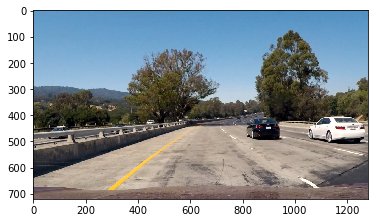

In [16]:
test_img = io.imread('test_images/test1.jpg')
plt.imshow(test_img);

In [19]:
def slide_window_multi_scale(img):
    window_list = list()
    img_y, img_x = img.shape[0], img.shape[1]
    window_list += slide_window_uniform(img, x_start_stop=[None, None], y_start_stop=[int(img_y*0.4), None], 
                    xy_window=(int(img_x/3), int(img_x/3)), xy_overlap=(0.5, 0.0))[:3*2]
    window_list += slide_window_uniform(img, x_start_stop=[None, None], y_start_stop=[int(img_y*0.5), None], 
                    xy_window=(int(img_x/5), int(img_x/5)), xy_overlap=(0.5, 0.0))[:5*2]
    window_list += slide_window_uniform(img, x_start_stop=[None, None], y_start_stop=[int(img_y*0.52), None], 
                    xy_window=(int(img_x/7), int(img_x/7)), xy_overlap=(0.5, 0.0))[:7*2]
    window_list += slide_window_uniform(img, x_start_stop=[None, None], y_start_stop=[int(img_y*0.55), None], 
                    xy_window=(int(img_x/9), int(img_x/9)), xy_overlap=(0.5, 0.0))[:11*2]
    window_list += slide_window_uniform(img, x_start_stop=[None, None], y_start_stop=[int(img_y*0.57), None], 
                    xy_window=(int(img_x/13), int(img_x/13)), xy_overlap=(0.5, 0.0))[:13*2]
    window_list += slide_window_uniform(img, x_start_stop=[None, None], y_start_stop=[int(img_y*0.57), None], 
                    xy_window=(int(img_x/20), int(img_x/20)), xy_overlap=(0.5, 0.0))[:20*2]
    return window_list

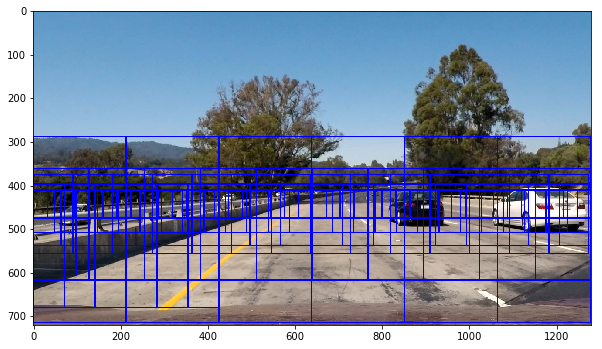

In [20]:
windows = slide_window_multi_scale(test_img)
                       
window_img = draw_boxes(test_img, windows, color=(0, 0, 255), thick=2)           
plt.figure(figsize=(10,10))
plt.imshow(window_img);

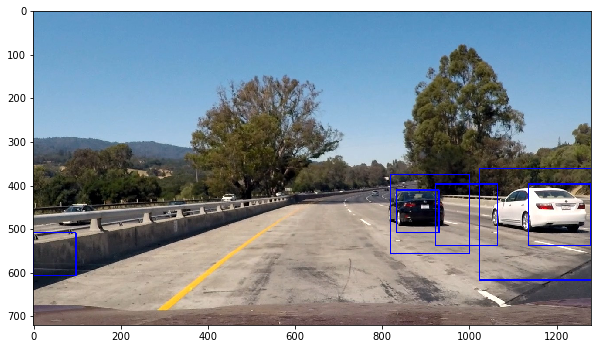

In [21]:
windows = slide_window_multi_scale(test_img)
hot_windows = search_windows(test_img, windows, clf)
hot_window_img = draw_boxes(test_img, hot_windows, color=(0, 0, 255), thick=2)    
plt.figure(figsize=(10,10))
plt.imshow(hot_window_img);